In [1]:
from keras.applications import vgg16

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224
VGG=vgg16.VGG16(weights='imagenet',include_top=False ,input_shape=(img_rows, img_cols,3))

In [3]:
for layer in VGG.layers:
    layer.trainable=False

In [4]:
def top(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 3

FC_Head = top(VGG, num_classes)

model = Model(inputs = VGG.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/My Drive/Celeb_Dataset/train/'
validation_data_dir = '/content/drive/My Drive/Celeb_Dataset/validation/'
 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 236 images belonging to 3 classes.
Found 57 images belonging to 3 classes.


In [7]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("celeb_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]
 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])

nb_train_samples = 236
nb_validation_samples = 57
 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
14/14 [==============================] - 14s 1s/step - loss: 1.1018 - accuracy: 0.3456 - val_loss: 1.0315 - val_accuracy: 0.5618

Epoch 00001: val_loss improved from inf to 1.03146, saving model to celeb_vgg.h5
Epoch 2/5
14/14 [==============================] - 6s 434ms/step - loss: 1.0467 - accuracy: 0.4461 - val_loss: 0.9796 - val_accuracy: 0.7195

Epoch 00002: val_loss improved from 1.03146 to 0.97959, saving model to celeb_vgg.h5
Epoch 3/5
14/14 [==============================] - 7s 476ms/step - loss: 1.0149 - accuracy: 0.5327 - val_loss: 0.8796 - val_accuracy: 0.6629

Epoch 00003: val_loss improved from 0.97959 to 0.87956, saving model to celeb_vgg.h5
Epoch 4/5
14/14 [==============================] - 6s 449ms/step - loss: 0.9706 - accuracy: 0.5588 - val_loss: 0.9500 - val_accuracy: 0.7073

Epoch 00004: val_loss did not improve from 0.87956
Epoch 5/5
14/14 [==============================] - 6s 457ms/step - loss: 0.9568 - accuracy: 0.5515 - val_loss: 0.8665 - val_accuracy

In [8]:
from keras.models import load_model

classifier = load_model('celeb_vgg.h5')

Class - Vicky


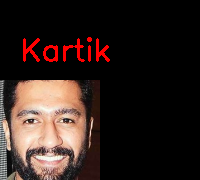

Class - Ayushmann


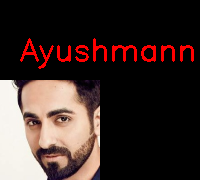

Class - Vicky


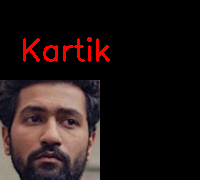

Class - Ayushmann


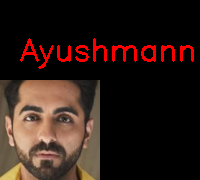

Class - Vicky


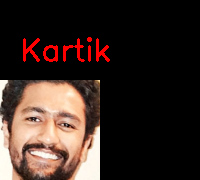

Class - Ayushmann


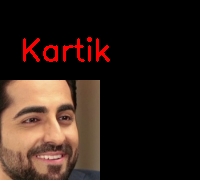

Class - Kartik


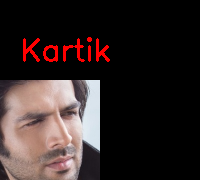

Class - Kartik


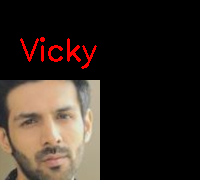

Class - Ayushmann


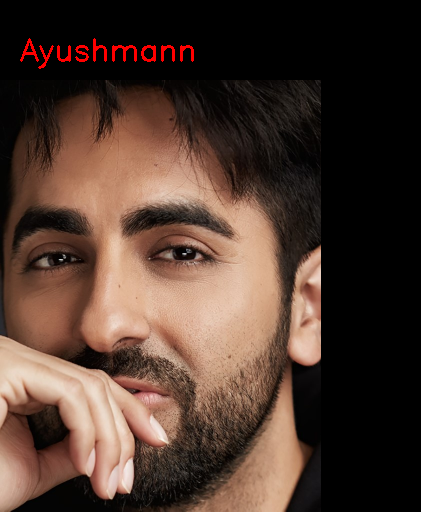

Class - Ayushmann


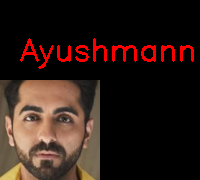

In [9]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow

celeb_dict = {"[0]": "Ayushmann", 
              "[1]": "Vicky",
              "[2]": "Kartik"}

celeb_dict_n = {"Ayushmann": "Ayushmann", 
                "Vicky": "Vicky",
                "Kartik":"Kartik"}

def draw_test(name, pred, im):
    celeb = celeb_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, celeb, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + celeb_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/drive/My Drive/Celeb_Dataset/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    draw_test("Prediction", res, input_original) 